In [2]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import xarray as xr
from xclim.indices.generic import select_resample_op
from xclim.indices.stats import fit, parametric_quantile
import numpy as np
from scipy.stats import genextreme as gev
import geopandas as gp
import regionmask

In [3]:
ds = xr.open_dataset('/g/data/xv83/bxn599/CaRSA/agcd_v1_concatenated/agcd_v1_tmax_mean_r005_daily_1980-2019.nc')

In [4]:
ds['tmax'].attrs = {
    'standard_name': 'air_temperature',
    'long_name': 'Daily Maximum Near-Surface Air Temperature',
    'units': 'degC',
}

In [5]:
ds

<xarray.Dataset>
Dimensions:    (time: 14610, bnds: 2, lon: 886, lat: 691)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T09:00:00 ... 2019-12-31T09:00:00
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lon_bnds   (lon, bnds) float32 ...
    lat_bnds   (lat, bnds) float32 ...
    crs        int32 ...
    tmax       (time, lat, lon) float32 ...
Attributes: (12/35)
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    history:                   Mon Oct 04 06:03:36 2021: cdo cat agcd_v1_tmax...
    source:                    Data is from site-based observation data recor...
    institution:               Australian Bureau of Meteorology, GPO Box 1289...
    Conventions:               CF-1.6, ACDD-1.3
    geospatial_lat_min:        -44.525
    ...                        ...
    licence:                   Data Licence: The grid data files in this AGCD...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2020-12-02 09:15:40
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2020, ...
    CDO:                       Climate Data Operators version 1.9.8 (https://...

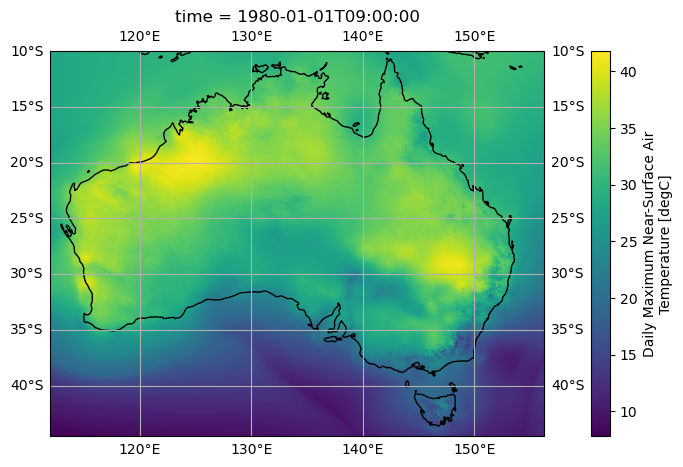

In [6]:
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds['tmax'].isel({'time': 0}).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
)
ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
)
ax.coastlines()
plt.show()

In [7]:
def select_shapefile_regions(ds, shapes, lat_dim="lat", lon_dim="lon"):
    """Select region/s using a shapefile.
    Parameters
    ----------
    ds : xarray DataArray or Dataset
    shapes : geopandas GeoDataFrame
        Shapes/regions
    lat_dim: str, default 'lat'
        Name of the latitude dimension in ds
    lon_dim: str, default 'lon'
        Name of the longitude dimension in ds
    Returns
    -------
    ds : xarray DataArray or Dataset
    Notes
    -----
    Grid cells are selected if their centre point falls within the shape.
    
    regionmask requires the names of the horizontal spatial dimensions
    to be 'lat' and 'lon'
    """

    new_dim_names = {}
    if not lat_dim == "lat":
        new_dim_names[lat_dim] = "lat"
    if not lon_dim == "lon":
        new_dim_names[lon_dim] = "lon"
    if new_dim_names:
        ds = ds.rename_dims(new_dim_names)
    assert "lat" in ds.coords, "Latitude coordinate must be called lat"
    assert "lon" in ds.coords, "Longitude coordinate must be called lon"

    lons = ds["lon"].values
    lats = ds["lat"].values

    mask = regionmask.mask_geopandas(shapes, lons, lats)
    mask = mask.rename("region")

    mask = _nan_to_bool(mask)
    ds = ds.where(mask)
    ds = ds.dropna("lat", how="all")
    ds = ds.dropna("lon", how="all")

    return ds


def _nan_to_bool(mask):
    """Convert array of NaNs and floats to booleans.
    Parameters
    ----------
    mask : xarray DataArray
        Data array of NaN's and floats
    Returns
    -------
    mask : xarray DataArray
        Data array of True (where floats were) and False (where NaNs were) values
    """

    assert type(mask) == xr.core.dataarray.DataArray
    if mask.values.dtype != "bool":
        mask = xr.where(mask.notnull(), True, False)

    return mask

In [8]:
land_boundary = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

In [9]:
ds_masked = select_shapefile_regions(ds.sel({'time': slice('1990-01-01', '1999-12-31')}), land_boundary) 

In [10]:
ds_masked['tmax'].isel({'lat': 0, 'lon': 0})

<xarray.DataArray 'tmax' (time: 3652)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T09:00:00 ... 1999-12-31T09:00:00
    lon      float32 112.9
    lat      float32 -43.6
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    units:          degC

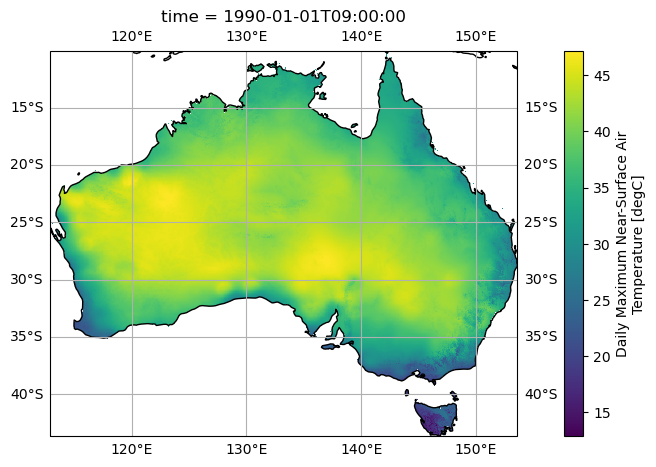

In [11]:
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_masked['tmax'].isel({'time': 0}).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
)
ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
)
ax.coastlines()
plt.show()

In [15]:
def fit_distribution(da, ilat, ilon, method='PWM'):
    """Attempt to fit a distribution"""
    
    da_point = da.isel({'lat': ilat, 'lon': ilon}).compute()
    lat = float(da_point['lat'].values)
    lon = float(da_point['lon'].values)
    print(f'lat: {lat}, lon: {lon}')
    
    block_values = select_resample_op(da_point, op='max', freq='Y')
    params = fit(block_values, dist='genextreme', method=method)
    ev = parametric_quantile(params, q=0.95)
    print(ev.values)

In [16]:
#for ilat in range(len(ds['lat'])):
#    for ilon in range(len(ds['lon'])):
fit_distribution(ds['tmax'], 0, 0, method='ML')

lat: -44.5, lon: 112.0
[13.48535156]


In [18]:
fit_distribution(ds_masked['tmax'], 0, 0, method='ML')

lat: -43.599998474121094, lon: 112.94999694824219
[nan]


In [17]:
fit_distribution(ds['tmax'], 0, 0, method='PWM')

lat: -44.5, lon: 112.0


/g/data/wp00/users/dbi599/miniconda3/envs/cih/lib/python3.10/site-packages/lmoments3/__init__.py:179: RuntimeWarning: invalid value encountered in double_scalars
  l3 = coefl3 * sum_xtrans / l2


ValueError: L-Moments Invalid

In [19]:
fit_distribution(ds_masked['tmax'], 0, 0, method='PWM')

lat: -43.599998474121094, lon: 112.94999694824219
[nan]


In [16]:
def plot_data(lat, lon):
    """Peform EVA analysis for a particular grid point."""
    
    da = ds['tmax'].sel({'lat': lat, 'lon': lon}, method='nearest').compute()
    da.plot()
    plt.show()
    
    block_values = select_resample_op(da, op='max', freq='Y')
    block_values.plot()
    plt.show()

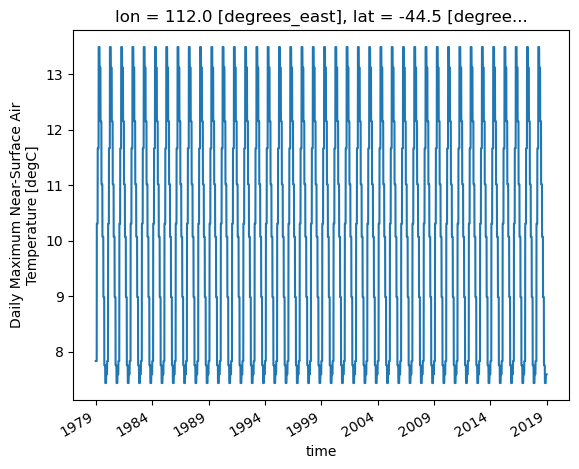

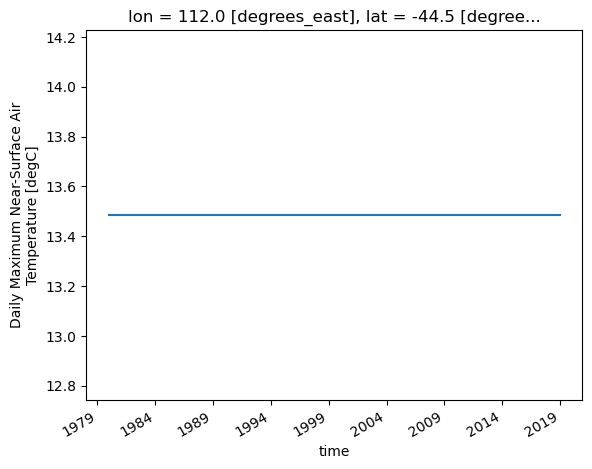

In [17]:
plot_data(-44.5, 112)

In [65]:
def eva_analysis(lat, lon, pdf_xvals):
    """Peform EVA analysis for a particular grid point."""
    
    da = ds['tmax'].sel({'lat': lat, 'lon': lon}, method='nearest').compute()
    da.plot()
    plt.show()
    
    block_values = select_resample_op(da, op='max', freq='Y')
    block_values.plot()
    plt.show()
    
    params = fit(block_values, dist='genextreme', method='PWM')
    
    ev = parametric_quantile(params, q=0.95)
    print(ev.values)
    
    block_values_ds = block_values.to_pandas()
    gev_shape, gev_loc, gev_scale = params.values
    
    fig, ax = plt.subplots(figsize=[6, 4]) 
    block_values_ds.plot.hist(bins=20, density=True, color='tab:green', alpha=0.5)
    gev_pdf = gev.pdf(pdf_xvals, gev_shape, gev_loc, gev_scale)
    plt.plot(pdf_xvals, gev_pdf, color='tab:green', linewidth=4.0)
    plt.xlabel('tmax (C)')
    plt.ylabel('probability')
    plt.title(f'TXx (latitude: {lat}, longitude: {lon})')
    plt.show()

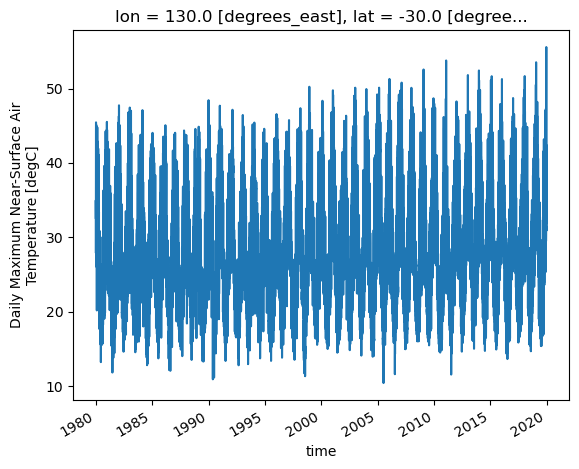

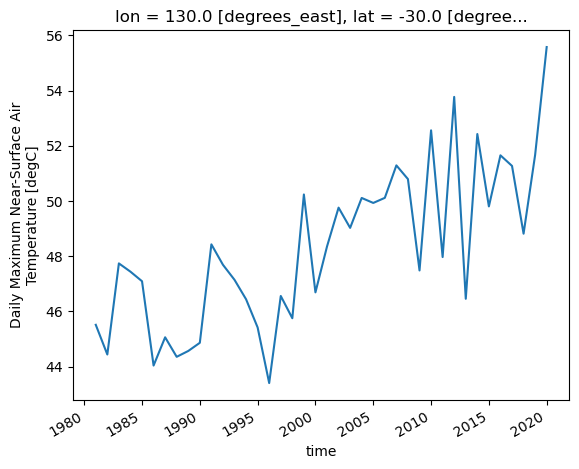

[53.61705747]


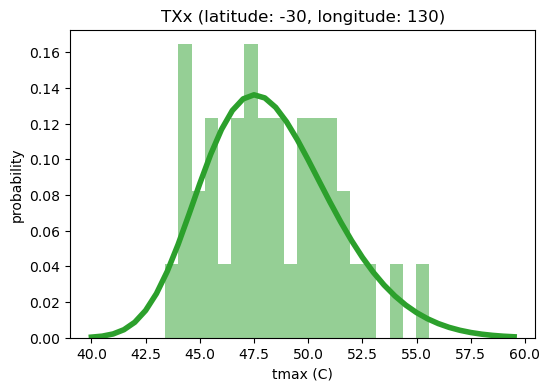

In [66]:
eva_analysis(-30, 130, np.arange(40, 60, 0.5))

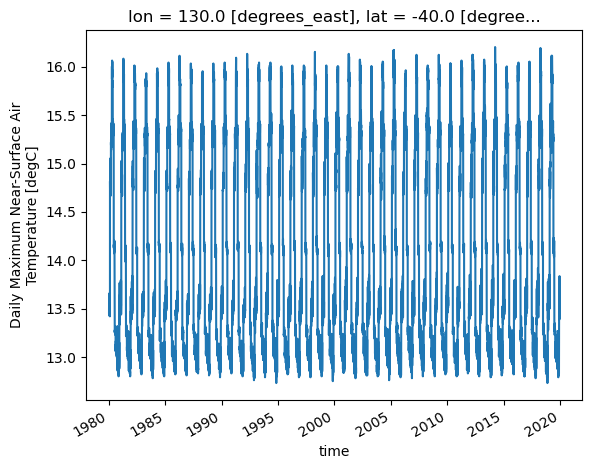

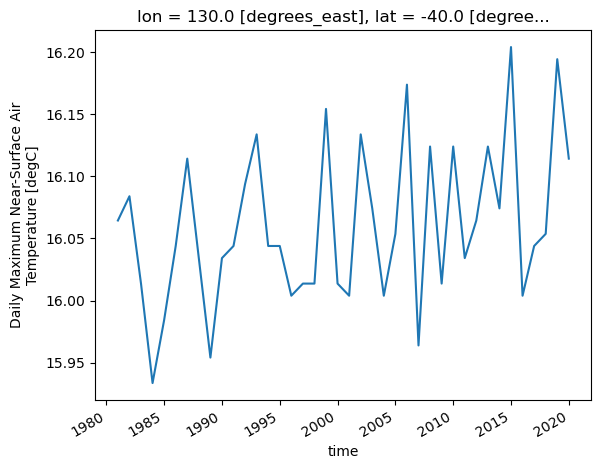

[16.1789391]


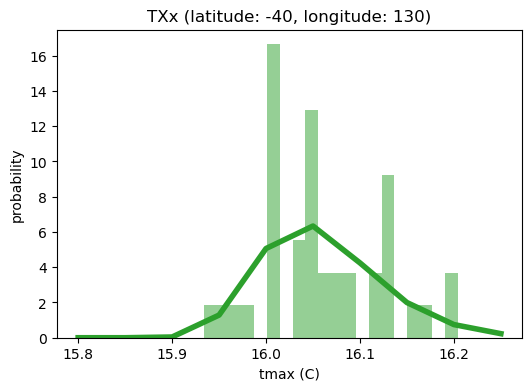

In [69]:
eva_analysis(-40, 130, np.arange(15.8, 16.3, 0.05))